<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/BandOffSet_QE_InterMat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install quantum espresso

In [1]:
%%time
import os
os.chdir('/content')
# Clone the QE git
if not os.path.exists('q-e'):
   os.system('git clone https://github.com/QEF/q-e.git')
# Install the dependencies
!apt-get install -y libfftw3-3 libfftw3-dev libfftw3-doc
os.chdir('q-e')
# run the configure file
#!DFLAGS='-D__OPENMP -D__FFTW3 -D__MPI -D__SCALAPACK' FFT_LIBS='-lfftw3'  ./configure --enable-openmp

!!DFLAGS='-D__FFTW3 ' FFT_LIBS='-lfftw3'  ./configure
! make pw

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
The following NEW packages will be installed:
  libfftw3-3 libfftw3-bin libfftw3-dev libfftw3-doc libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3
0 upgraded, 8 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,918 kB of archives.
After this operation, 26.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-single3 amd64 3.3.8-2ubuntu8 [800 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libfftw3-3 amd64 3.3.8-2ubuntu8 [1,756 B]
Get:5 http://archive.ubuntu.com

In [2]:
!make pp

test -d bin || mkdir bin
( cd UtilXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/UtilXlib'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/q-e/UtilXlib'
cd install ; make -f extlibs_makefile libcuda
make[1]: Entering directory '/content/q-e/install'
make[1]: Nothing to be done for 'libcuda'.
make[1]: Leaving directory '/content/q-e/install'
( cd LAXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/LAXlib'
make[1]: Nothing to be done for 'all'.
make[1]: Leaving directory '/content/q-e/LAXlib'
( cd FFTXlib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/FFTXlib'
( cd src ; make all || exit 1 )
make[2]: Entering directory '/content/q-e/FFTXlib/src'
make[2]: Nothing to be done for 'all'.
make[2]: Leaving directory '/content/q-e/FFTXlib/src'
make[1]: Leaving directory '/content/q-e/FFTXlib'
( cd upflib ; make TLDEPS= all || exit 1 )
make[1]: Entering directory '/content/q-e/upflib'

In [3]:
!pip install -qqq intermat spglib ase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 54.6 MB/s eta 0:00:00


In [4]:
import os
os.chdir('/content')

In [29]:
from jarvis.core.atoms import Atoms
from jarvis.io.vasp.inputs import Poscar
from intermat.generate import InterfaceCombi
import numpy as np
film_pos = """MoS2
1.0
1.5939818713880687 -2.7608568870413697 0.0
1.5939818713880687 2.7608568870413697 0.0
0.0 0.0 34.879004
Mo S
1 2
Cartesian
1.59398 -0.9202885072399822 3.7197407130000837
1.59398 0.9202885072399822 2.153121547584768
1.59398 0.9202885072399822 5.286394757415309
"""
subs_pos = """Te2Mo
1.0
1.7811816828576317 -3.08509790977307 0.0
1.7811816828576317 3.08509790977307 0.0
0.0 0.0 35.346645
Te Mo
2 1
Cartesian
1.78118 -1.02836872339998 2.024632306765125
1.78118 -1.02836872339998 5.648699077555013
1.78118 1.0283687233999803 3.8366656921600706
"""

film_pos = """Si2
1.0
3.3641499856336465 -2.5027128e-09 1.94229273881412
1.121382991333525 3.1717517190189715 1.9422927388141193
-2.5909987e-09 -1.8321133e-09 3.884586486670313
Si
2
Cartesian
3.92483875 2.77528125 6.7980237500000005
0.56069125 0.39646875 0.9711462500000001
"""
subs_pos = """GaAs
1.0
3.509895098013499 -6.584084e-10 2.026439508259945
1.169965032050413 3.3091606691404545 2.026439508259945
-1.8622597e-09 -1.3168164e-09 4.052878022970947
Ga As
1 1
Cartesian
0.0 0.0 0.0
1.1699675 0.82729 2.02644
"""


film = Poscar.from_string(film_pos).atoms
subs = Poscar.from_string(subs_pos).atoms

x = InterfaceCombi(
    film_mats=[film],
    subs_mats=[subs],
    film_indices=[[1,1,0]],
    subs_indices=[[1,1,0]],
    disp_intvl=0.0,
    vacuum_interface=2,
    dataset=None,
    from_conventional_structure_film=True,
    from_conventional_structure_subs=True,
)
wads = x.calculate_wad(method="ewald")
index = np.argmin(wads) # important for disp_intvl not equal zero
combined = Atoms.from_dict(x.generated_interfaces[index]["generated_interface"])
film_interface = Atoms.from_dict(x.generated_interfaces[index]["film_surf"]).center(vacuum=6)
subs_interface = Atoms.from_dict(x.generated_interfaces[index]["subs_surf"]).center(vacuum=6)


Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699
Loading the zipfile...


/usr/local/lib/python3.10/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['international']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/intermat/generate.py:52: RuntimeWarning: invalid value encountered in scalar divide
  strain_x = (
/usr/local/lib/python3.10/dist-packages/intermat/generate.py:55: RuntimeWarning: invalid value encountered in scalar divide
  strain_y = (


Loading completed.
len generated 1


100%|██████████| 1/1 [00:00<00:00,  4.40it/s]


In [30]:
from ase.visualize import view
view(combined.ase_converter(),viewer='x3d')

In [31]:
from ase.visualize import view
view(film_interface.ase_converter(),viewer='x3d')

In [32]:
from ase.visualize import view
view(subs_interface.ase_converter(),viewer='x3d')

In [9]:
os.chdir('/content')

In [36]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=film_interface,
    extra_params=params,
    jobname="film_job",
)
out_film= calc.predict()
en = out_film["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/film_job/film_job/RELAX.save/data-file-schema.xml
-3106.2733623440085
CPU times: user 1.16 s, sys: 257 ms, total: 1.42 s
Wall time: 7min 2s


In [34]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=subs_interface,
    extra_params=params,
    jobname="subs_job",
)
out_subs= calc.predict()
en = out_subs["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/film_job/subs_job/RELAX.save/data-file-schema.xml
-74279.17413904301
CPU times: user 10 s, sys: 1.36 s, total: 11.4 s
Wall time: 29min 7s


In [35]:
%%time
from intermat.config import IntermatConfig
from intermat.calculators import Calc
params = IntermatConfig().dict()
qe_cmd = "/content/q-e/bin/pw.x"
params['kp_length'] = 0
params['qe_params']['qe_cmd'] = qe_cmd

method = "qe"
calc = Calc(
    method=method,
    atoms=combined,
    extra_params=params,
    jobname="interface_job",
)
out_int= calc.predict()
en = out_int["total_energy"]
print(en)

Please cite for PSPs:
https://doi.org/10.1016/j.commatsci.2013.08.053
Sanitizing Atoms.
cmd /content/q-e/bin/pw.x<arelax.in
HERE1
HERE2 /content/film_job/interface_job/RELAX.save/data-file-schema.xml
-77386.72191811608
CPU times: user 23.6 s, sys: 3.22 s, total: 26.8 s
Wall time: 1h 17min 13s


In [13]:
os.chdir('/content')

### Post-processing

In [37]:
lines="""&inputPP
   outdir='film_job',
   prefix='RELAX',
   plot_num=11,
   filplot = 'film.pot'
/

&plot
   filplot(1) = 'film.pot'
   iflag=3,
   output_format=5
/
"""
with open("pp_film.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_film.in


     Program POST-PROC v.7.3.1 starts on 30Sep2024 at  3:32:34 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8272 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     film_job/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-

In [38]:
lines="""&inputPP
   outdir='interface_job',
   prefix='RELAX',
   plot_num=11,
   filplot = 'interface.pot'
/

&plot
   filplot(1) = 'interface.pot'
   iflag=3,
   output_format=5
/
"""
with open("pp_interface.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_interface.in


     Program POST-PROC v.7.3.1 starts on 30Sep2024 at  3:32:55 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8190 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     interface_job/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


  

In [39]:
lines="""&inputPP
   outdir='subs_job',
   prefix='RELAX',
   plot_num=11,
   filplot = 'subs.pot'
/

&plot
   filplot(1) = 'subs.pot'
   iflag=3,
   output_format=5
/
"""
with open("pp_subs.in","w") as f:
    f.write(lines)
!/content/q-e/bin/pp.x<pp_subs.in


     Program POST-PROC v.7.3.1 starts on 30Sep2024 at  3:33:12 

     This program is part of the open-source Quantum ESPRESSO suite
     for quantum simulation of materials; please cite
         "P. Giannozzi et al., J. Phys.:Condens. Matter 21 395502 (2009);
         "P. Giannozzi et al., J. Phys.:Condens. Matter 29 465901 (2017);
         "P. Giannozzi et al., J. Chem. Phys. 152 154105 (2020);
          URL http://www.quantum-espresso.org", 
     in publications or presentations arising from this work. More details at
     http://www.quantum-espresso.org/quote

     Serial version
     8187 MiB available memory on the printing compute node when the environment starts


     Reading xml data from directory:

     subs_job/RELAX.save/

     IMPORTANT: XC functional enforced from input :
     Exchange-correlation= PBESOL
                           (   1   4  10   8   0   0   0)
     Any further DFT definition will be discarded
     Please, verify this is what you really want


     G-

In [40]:
def read_pot(filename="film.pot"):
    f=open(filename,"r")
    lines = f.readlines()
    f.close()
    line = lines[1].split()
    grid=[int(line[0]),int(line[1]),int(line[2])]
    natoms=int(line[6])
    species=int(line[7])
    header=7
    skip_lines=header+natoms+species
    chg=[]
    for line in lines[skip_lines:]:
        for j in line.split('/n')[0].split():
          chg.append(float(j))
    chg=np.array(chg).reshape(grid)
    return chg
film_pot = read_pot(filename="film.pot")
subs_pot = read_pot(filename="subs.pot")
interface_pot = read_pot(filename="interface.pot")


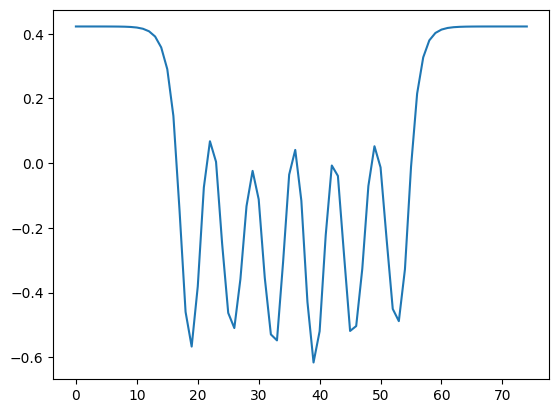

In [41]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.mean(film_pot,tuple([1,2])))

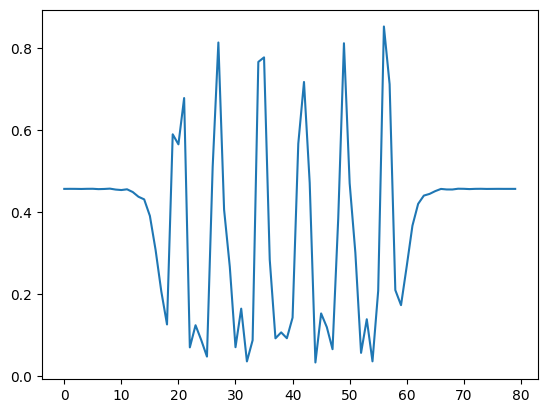

In [42]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.mean(subs_pot,tuple([1,2])))

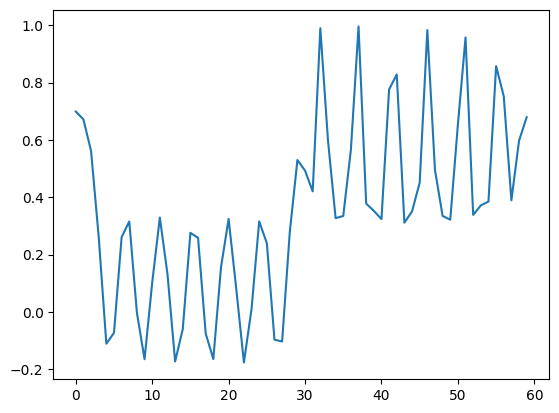

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.mean(interface_pot,tuple([1,2])))

In [ ]:
from jarvis.io.qe.outputs import DataFileSchema
d=DataFileSchema("film/RELAX.save/data-file-schema.xml")
d.data['qes:espresso']['output']['basis_set']

In [ ]:
import pprint
nr1=int(d.data['qes:espresso']['output']['basis_set']['fft_grid']['@nr1'])
nr2=int(d.data['qes:espresso']['output']['basis_set']['fft_grid']['@nr2'])
nr3=int(d.data['qes:espresso']['output']['basis_set']['fft_grid']['@nr3'])

In [ ]:
d.data['qes:espresso']['output']['basis_set']

{'gamma_only': 'false',
 'ecutwfc': '2.250000000000000E+001',
 'ecutrho': '1.250000000000000E+002',
 'fft_grid': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'fft_smooth': {'@nr1': '27', '@nr2': '27', '@nr3': '125'},
 'fft_box': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'ngm': '59987',
 'ngms': '36549',
 'npwx': '4585',
 'reciprocal_lattice': {'b1': '1.000000000000000E+000  5.773502691896258E-001 -0.000000000000000E+000',
  'b2': '0.000000000000000E+000  1.154700538379252E+000  0.000000000000000E+000',
  'b3': '0.000000000000000E+000 -0.000000000000000E+000  2.106593052536925E-001'}}

In [ ]:
59987/36

1666.3055555555557

In [ ]:
nr1,nr2,nr3

(36, 36, 144)

In [ ]:
data.shape

(209969,)

In [ ]:
nr1*nr2*nr3

186624

In [ ]:
839876/186624

4.500364368998628

In [ ]:
d.data['qes:espresso']['output']['basis_set']

{'gamma_only': 'false',
 'ecutwfc': '2.250000000000000E+001',
 'ecutrho': '1.250000000000000E+002',
 'fft_grid': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'fft_smooth': {'@nr1': '27', '@nr2': '27', '@nr3': '125'},
 'fft_box': {'@nr1': '36', '@nr2': '36', '@nr3': '144'},
 'ngm': '59987',
 'ngms': '36549',
 'npwx': '4585',
 'reciprocal_lattice': {'b1': '1.000000000000000E+000  5.773502691896258E-001 -0.000000000000000E+000',
  'b2': '0.000000000000000E+000  1.154700538379252E+000  0.000000000000000E+000',
  'b3': '0.000000000000000E+000 -0.000000000000000E+000  2.106593052536925E-001'}}